In [1]:
!nvidia-smi

Mon Nov 18 21:12:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [0]:
X = np.load('X.npy')
y = np.load('y.npy')

In [4]:
X.shape

(4824, 60, 80, 3)

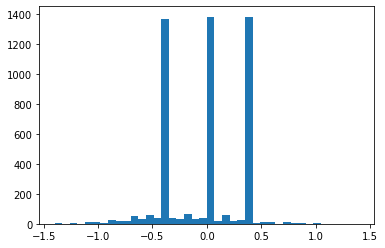

In [5]:
plt.hist(y,40);

In [0]:
import imgaug
from imgaug import augmenters as iaa
from imgaug import parameters as iap

In [0]:
def augment(img, steering_angle):
  #Flip
  if random.random() > 0.5:
    img = img[:,::-1,:]
    steering_angle =-steering_angle
  #Blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1,1.0))
  img = blurer.augment_image(img)
  #Change colors
  # sh = iaa.ChannelShuffle(p=0.5)
  # img= sh.augment_image(img)
  #fog
  fog = iaa.FastSnowyLandscape()
  fog.augment_image(img)
  img = fog.augment_image(img)
  #translate
  tx = random.randint(-20, 20)
  translater = iaa.Affine(translate_px={"x": tx}, mode='edge')
  img = translater.augment_image(img)
  steering_angle -= tx *0.025

  return img, steering_angle


In [0]:
img,angle = augment(X[0], y[0])

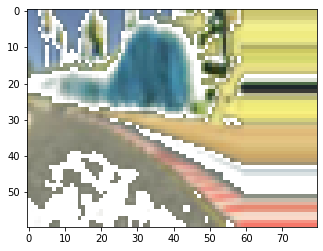

In [9]:
plt.imshow(img)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
X_train.shape

(3859, 60, 80, 3)

In [0]:
Xgen=[]
ygen=[]
for i in range(X_train.shape[0]):
  img, angle = augment(X[i], y[i])
  Xgen.append(img)
  ygen.append(angle)

Xgen = np.array(Xgen)
ygen = np.array(ygen)

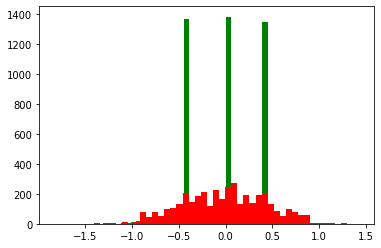

In [12]:
plt.hist(y, 50, facecolor='green');
plt.hist(ygen, 50, facecolor='red');


In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D, Lambda
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [14]:
def myModel(input_shape):
  model = Sequential(
      [Lambda(lambda x: (x-128.0)/255.0, input_shape=input_shape, name='normalize'),
      Conv2D(64, (3,3), activation='relu'),
       MaxPooling2D(pool_size=(2,2)),
       Conv2D(32, (3,3), activation='relu'),
       MaxPooling2D(pool_size=(2,2)),
       Conv2D(8, (3,3), activation='relu'),
       MaxPooling2D(pool_size=(2,2)),
       Dropout(0.5),
       Flatten(),
       Dense(512, activation='relu'),
       Dropout(0.5),
       Dense(512, activation='relu'),
       Dropout(0.5),
       Dense(16, activation='relu'),
       Dense(1)  ])
  return model

model = myModel(X[0].shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [54]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 29, 39, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 27, 37, 32)        18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 18, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 16, 8)         2312      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 8, 8)          

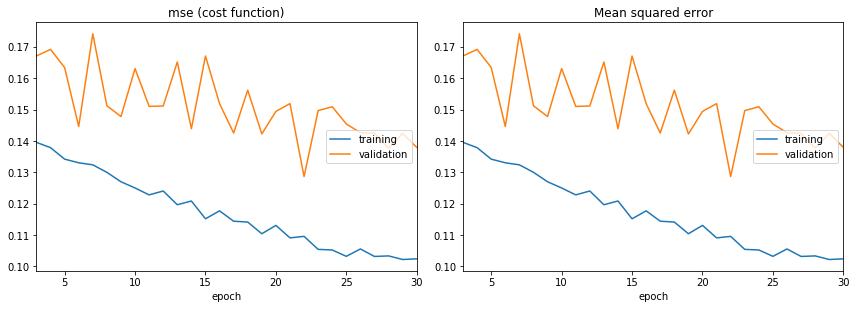

mse (cost function):
training   (min:    0.102, max:    0.147, cur:    0.102)
validation (min:    0.129, max:    0.180, cur:    0.138)

Mean squared error:
training   (min:    0.102, max:    0.147, cur:    0.102)
validation (min:    0.129, max:    0.180, cur:    0.138)


In [63]:
batch_size = 512
epochs = 30

# model.compile(optimizer='adam') 
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


model.fit(Xgen, ygen, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
          callbacks=[PlotLossesKeras()])

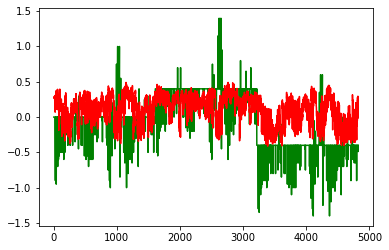

In [66]:
ypred = model.predict(X)
plt.plot(y,'green', ypred, 'red')
plt.show()

In [0]:
model.save('mymodel.h5')

In [15]:
import autokeras as ak
model_ak = ak.ImageRegressor(verbose=True)
model_ak.fit(Xgen, ygen, time_limit=10*60)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
Saving Directory: /tmp/autokeras_9ETDM1
Preprocessing the images.
Preprocessing finished.

Initializing search.
Initialization finished.


+----------------------------------------------+
|               Training model 0               |
+----------------------------------------------+
                                                                                                    
No loss decrease after 5 epochs.


Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           0            |   0.6345995455980301   |  0.20422437237276236   |
+--------------------------------------------------------------------------+


+----------------------------------------------+
|               Training model 1      

In [0]:
score = model_ak.evaluate(X_val, y_val)

In [0]:
ypred2 = model_ak.predict(X)
plt.plot(y, 'g', ypred2, 'r')
plt.show()